# Regularization

In [1]:
%matplotlib inline

* Regularization refers to techniques that improve the generalizability of a trained model.
* We will guide you through some common regularization techniques such as **weight decay, sparse weight, and validation**.

# <a name='LT'>Learning Theory</a>
* Learning theory provides a means to understand the generalizability of trained model.
* It turns out that model comlexity plays a crucial role:
    * Too simple a model leads to **high bias and underfitting** because it cannot capture the trends or patterns in the underlying data generating distribution
    * Too complex a model leads to **high variance and overfitting** because it captures not only the trends of the underlying data generating distribution but also some patterns local to the training data

* Let's see the problems of [overfitting and underfitting](#OaU) from a toy regression problem. 
* Suppose we know the underlying data generating distribution:
$$P(x,y)=P(y|x)P(x)$$
where
$$\mathrm{P}(\mathrm{x})\sim\mathrm{Uniform}$$
and
$$\mathrm{y}= \sin(x) + \epsilon, \epsilon\sim\mathcal{N}(0,\sigma^2)$$
* We can generate a synthetic dataset as follows:

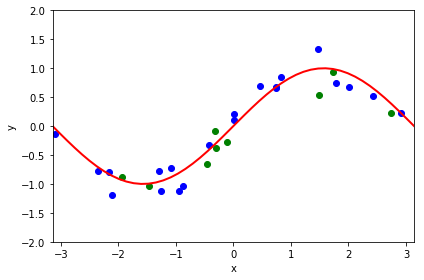

In [2]:
from pylab import *
from sklearn.model_selection import train_test_split

def gen_data(num_data, sigma):
    x = 2 * np.pi * (np.random.rand(num_data) - 0.5)
    y = np.sin(x) + np.random.normal(0, sigma, num_data)
    return (x, y)

num_data = 30
sigma = 0.2
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

plt.scatter(x_train, y_train, color='blue')
plt.scatter(x_test, y_test, color='green')

x_grid = np.linspace(-1*np.pi, 1*np.pi)
sin_x = np.sin(x_grid)
plt.plot(x_grid, sin_x, color ='red', linewidth = 2)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-np.pi, np.pi)
plt.ylim(-2, 2)
plt.tight_layout()
plt.savefig('./output/fig-dataset-sin.png', dpi=300)
plt.show()

* The blue points are training examples and the green ones are testing points.
* The red curve is the sin function, which is the function $f^*$ that has the minimal generalization error $C[f^*]$ (called the <a name='BackBE'>[Bayes error](BE)</a>).
* In regression, the degree P of a polynomial (polynomial regression) and the depth of a decision tree (decision tree regression) are both hyperparameters that relate to model complexity.

*  Let's consider the polynomial regression here and fit polynomials of degrees 1, 5, and 10 to 20 randomly generated training data of the same distribution:

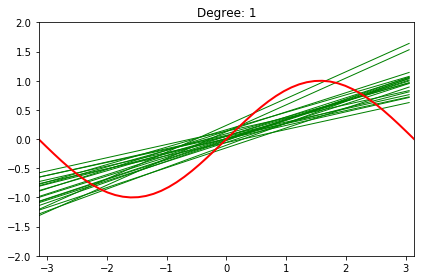

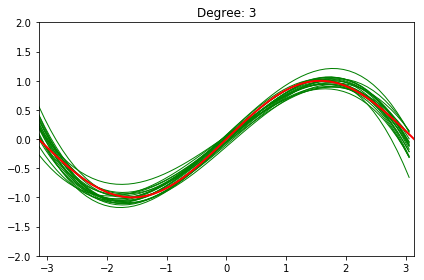

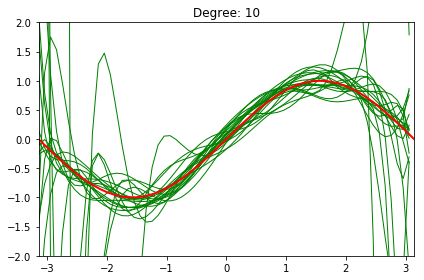

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

degree = [1, 3, 10]
std_list = []
for d in degree:
    X_fit = np.arange(-np.pi, np.pi, .1)[:, np.newaxis]
    poly = PolynomialFeatures(degree=d)
    
    for i in range(20):
        x, y = gen_data(num_data, sigma)
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.3, random_state=0)
        
        regr = LinearRegression()
        regr = regr.fit(poly.fit_transform(x_train[:,np.newaxis]), 
                        y_train[:,np.newaxis])

        y_fit = regr.predict(poly.transform(X_fit))
        plt.plot(X_fit, y_fit, 
                 color='green', lw=1)
    
    x_grid = np.linspace(-1*np.pi, 1*np.pi)
    sin_x = np.sin(x_grid)
    plt.plot(x_grid, sin_x, color='red', linewidth = 2)
    
    plt.title('Degree: %d' %d)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-2, 2)
    plt.tight_layout()
    plt.savefig('./output/fig-polyreg-%d.png' % d, dpi=300)
    plt.show()

* When P=1, the polynomial is too simple to capture the trend of the sin function.
* On the other hand, when P=10, the polynomial becomes too complex such that it captures the undesirable patterns of noises.
* $\color{red}{\text{Note:}}$
    * Regression is bad at extrapolation. You can see that the shape of a fitted polynomial differs a lot from the sin function outside the region where training points reside.

# Error Curves and Model Complexity
* One important conclusion we get from learning theory is that the model complexity plays a key role in generalization performance of a model.
* Let's plot the training and testing errors over different model complexities in our regression problem:

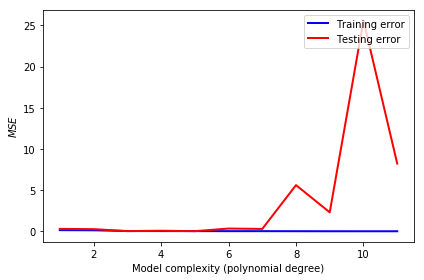

In [4]:
from sklearn.metrics import mean_squared_error

num_data = 50
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

mse_train = []
mse_test = []

max_degree = 12

for d in range(1, max_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(x_train[:,newaxis])
    X_test_poly = poly.transform(x_test[:,newaxis])
    
    regr = LinearRegression()
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = regr.predict(X_train_poly)
    y_test_pred = regr.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.savefig('./output/fig-error-curve.png', dpi=300)
plt.show()

* We can see that the training error (blue curve) decrease as the model complexity increases. 
* However, the testing error (red curve) decreases at the beginning but increases latter.
* We see a clear bias-variance tradeoff as discussed in the lecture.

# <a name='BackLC'>Learning Curves and Sample Complexity</a>
* More information about [learning curve](#LC)
* Although the error curve above visualizes the impact of model complexity, **the bias-variance tradeoff holds only when you have sufficient training examples**. 
* The bounding methods of learning theory tell us that a model is likely to overfit regardless of it complexity **when the size of training set is small**. 
*  The learning curves are a useful tool for understanding how much training examples are sufficient:

In [5]:
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

/home/epl/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/epl/.local/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


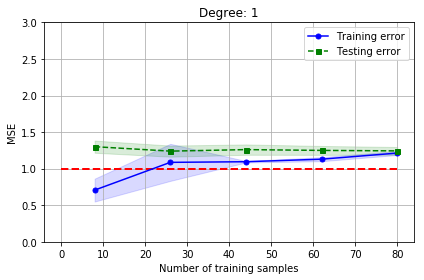

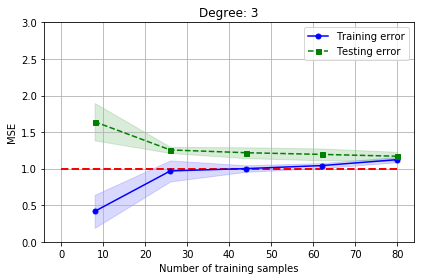

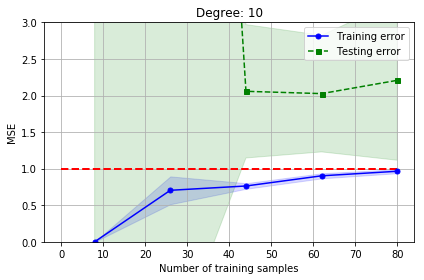

In [6]:
from sklearn.learning_curve import learning_curve

num_data = 120
sigma = 1
degree = [1, 3, 10]
x, y = gen_data(num_data, sigma)
for d in degree:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(x[:,np.newaxis])

    lr = LinearRegression()
    train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X, y=y, scoring=mse)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='Training error')
    plt.fill_between(train_sizes,
        train_mean+train_std,
        train_mean-train_std,
        alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Testing error')
    plt.fill_between(train_sizes,
        test_mean+test_std,
        test_mean-test_std,
        alpha=0.15, color='green')
    
    plt.hlines(y=sigma, xmin=0, xmax=80, color='red', linewidth=2, linestyle='--')
    
    plt.title('Degree: %d' % d)
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.ylim([0, 3])
    plt.tight_layout()
    plt.savefig('./output/fig-learning-curve-%d.png' % d, dpi=300)
    plt.show()

* We can see that, our regression task, a polynomial of any degree almost always overfit the training data when it's size is small, resulting in poor testing performance. 
*  This indicates that we should collect more data instead of sitting in front of the computer and play with the models. You may also try other models as different models has different sample complexity (i.e., number of samples required to successfully train a model).

# <a name='BackWD'>Weight Decay</a>
* Let's move on to the regularization techniques. 
* [Weight decay](#WD) is a common regularization approach. 
* **The idea is to add a term in the cost function against complexity.** 
* In regression, this leads to two well-known models:
    * [Ridge regression](#RR):
    $$\arg\min_{\boldsymbol{w},b}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert^{2}$$
    * [LASSO](#LASSO):
    $$\arg\min_{\boldsymbol{w},b}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert_{1}$$
* Let's see how they work using the Housing dataset:

In [7]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


* Remember that for weight decay to work properly, we need to ensure that **all our features are on comparable scales**:

In [8]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

# Ridge Regression
* We know that an unregularized polynomial regressor with degree P=3 will overfit the training data and has bad generalizability. Let's regularize its $L^{2}$-norm to see if we can get a better testing error:

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.3, random_state=0)

for a in [0, 1, 10, 100, 1000]:
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %d]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred)))  


[Alpha = 0]
MSE train: 0.00, test: 19958.68

[Alpha = 1]
MSE train: 0.73, test: 23.05

[Alpha = 10]
MSE train: 1.66, test: 16.83

[Alpha = 100]
MSE train: 3.60, test: 15.16

[Alpha = 1000]
MSE train: 8.81, test: 19.22


/home/epl/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.3189206934780695e-19 / 1.1102230246251565e-16
  RuntimeWarning)


* We can see that a small value α drastically reduces the testing error. 
* In addition, $\alpha=100$ seems to be a good decay strength. 
* As we can see, it's not a good idea to increase α forever, since it will over-shrink the coefficients of w and result in underfit.
--------------------------------------------------------
* Let's see the rate of weight decay as α grows:

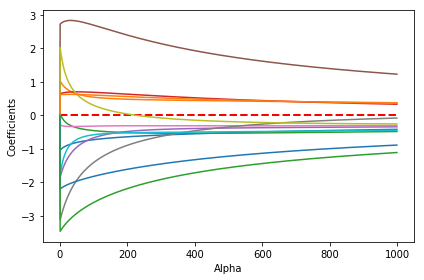

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 1000
coef_ = np.zeros((max_alpha, 13))

for a in range(1, max_alpha):
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

# LASSO
* An alternative weight decay approach that can lead to sparse $w$ is the LASSO.
* Depending on the value of $\alpha$, certain weights can become zero much faster than others, which makes the LASSO also useful as a supervised feature selection technique.
--------------------------
* $\color{red}{\text{Note:}}$
    * Since $L^{1}$-norm has non differentiable points, the solver (optimization method) is different from the one used in the Ridge regression. It would take much more time to train model weights.

In [11]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

for a in [0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %.2f]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred))) 


[Alpha = 0.00]
MSE train: 19.96, test: 27.20

[Alpha = 0.01]
MSE train: 19.96, test: 27.28

[Alpha = 0.10]
MSE train: 20.42, test: 28.33

[Alpha = 1.00]
MSE train: 26.04, test: 33.41

[Alpha = 10.00]
MSE train: 84.76, test: 83.77


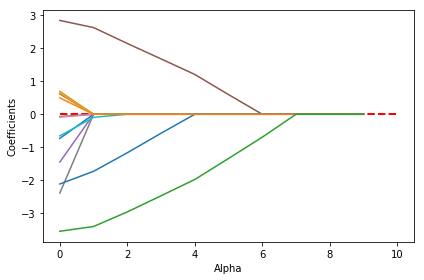

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 10
coef_ = np.zeros((max_alpha,13))

for a in range(10):
    lr_rg = Lasso(alpha=a+0.1)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

* The result shows that as the $\alpha$ increases, the coefficients shrink faster and become exactly zero when $\alpha$=8.

# LASSO for Feature Selection
* Since we can choose a suitable regularization strength $\alpha$ to make only part of coefficients become exactly zeros, **LASSO can also be treated as a feature selection technique**.

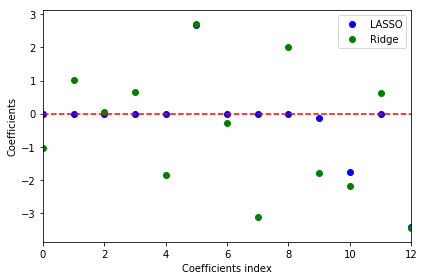

Selected attributes: ['RM' 'TAX' 'PTRATIO' 'LSTAT']


In [13]:
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 1)
lr_lasso.fit(X_train, y_train)
lr_ridge = Ridge(alpha = 1)
lr_ridge.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.scatter(range(var_num),lr_ridge.coef_, label = 'Ridge', color = 'green')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,12)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1e-4
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(df.columns.values[idxs]))

* We can plot the pairwise distributions to see the correlation between the selected attributes and MEDV:

All attributes:


/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


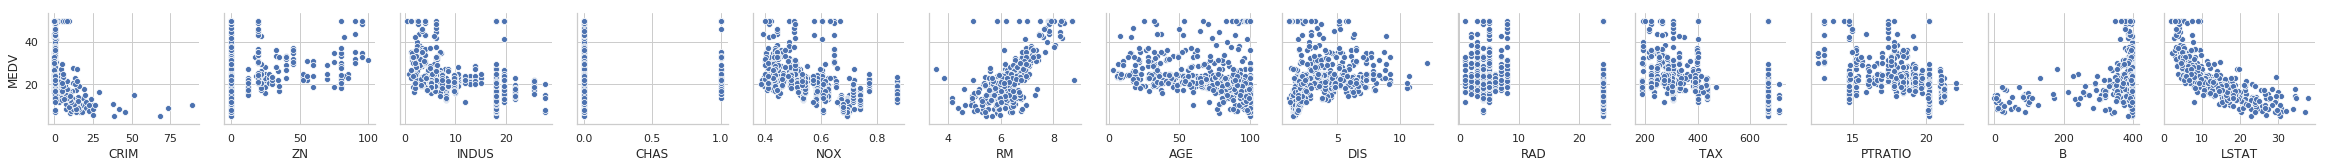

Selected attributes:


/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


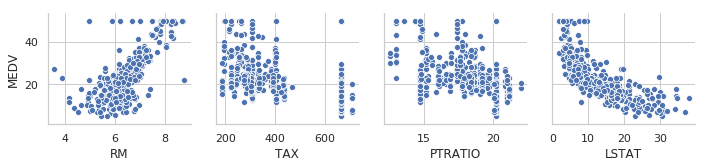

In [14]:
import seaborn as sns

print('All attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[:-1], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()

print('Selected attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df,x_vars=df.columns[idxs], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()
sns.reset_orig()

* As we can see, LASSO extracted attributes that have more significant correlations with MEDV.

# <a name='BackRANSAC'>Ignoring Outliers using RANSAC</a>
* Linear regression models can be heavily impacted by the presence of outliers.
* In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients, as shown below:
<img src='https://nthu-datalab.github.io/ml/labs/05_Regularization/fig-outlier.png' width='300'></img>
* There are many statistical tests that can be used to detect outliers, which are beyond the scope of our course. 
* However, removing outliers usually requires our human judgment as well as domain knowledge.
* Next, we present the [RANdom SAmple Consensus (RANSAC)](#RANSAC) algorithm for regression that can completely ignore the outliers and making them irrelevant to final predictions.
* RANSAC fits a regression model only to a subset of the data, the so-called [inliers](#I).
* RANSAC is an iterative algorithm, which can be summarized as follows:
    1. Select a random number of samples to be inliers and fit the model.
    2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
    3. Refit the model using all inliers.
    4. Estimate the error of the fitted model versus the inliers.
    5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached; go back to step 1 otherwise.

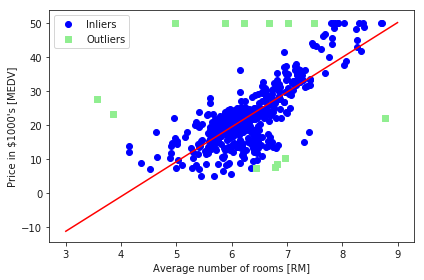


[RANSAC]
Slope (w_1): 10.22    Intercept (w_0): -41.93

[Ordinary least square]
Slope (w_1): 9.10    Intercept (w_0): -34.67


In [15]:
from sklearn.linear_model import RANSACRegressor

X = df['RM'].values[:, np.newaxis]
y = df['MEDV'].values

ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100, 
            min_samples=50, 
            residual_threshold=16.0, 
            random_state=0)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
print('\n[RANSAC]')
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(ransac.estimator_.coef_[0],ransac.estimator_.intercept_))


slr = LinearRegression()
slr.fit(X, y)
print('\n[Ordinary least square]')
y_pred = slr.predict(X)
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(slr.coef_[0],slr.intercept_))

* We set the maximum number of iterations of the $RANSACRegressor$ to 100, and via the $min_samples$ parameter we set the minimum number of the randomly chosen samples to be at least 50.
* Using the $residual_metric$ parameter, we provided a callable lambda function that simply calculates the absolute vertical distances between the fitted line and the sample points.
* By setting the residual_threshold parameter to 5.0, we only allowed samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units, which works well on this particular dataset.
* By default, scikit-learn uses the the <a name='BackMAD'>[Median Absolute Deviation (MAD)](#MAD)</a> estimate of the target values $y$ to select the inlier threshold.
* However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC.
* Many different approaches have been developed over the recent years to select a good inlier threshold automatically.

# Validation
* Hyperperemeters, i.e. model constants, may have impact on the model complexity and generalization performance.
* Validation is another useful regularization technique that helps us decide the proper value of a hyperparameter.
* **The idea is to split your data into the training, validation, and testing sets and then select the best value based on the Occam's razor for validation performance.** So, you don't peep testing set and report optimistic testing performance.

* Let's follow the structural risk minimization framework to pick a right degree P in polynomial regression:

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

for d in range(1, 7):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_std)

    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=0.3, random_state=0)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)
    
    rg = Ridge(alpha=100)
    rg.fit(X_train, y_train)
    
    y_train_pred = rg.predict(X_train)
    y_valid_pred = rg.predict(X_valid)
    y_test_pred = rg.predict(X_test)
    
    print('\n[Degree = %d]' % d)
    print('MSE train: %.2f, valid: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred),
                    mean_squared_error(y_test, y_test_pred))) 


[Degree = 1]
MSE train: 25.00, valid: 21.43, test: 32.09

[Degree = 2]
MSE train: 9.68, valid: 14.24, test: 20.24

[Degree = 3]
MSE train: 3.38, valid: 17.74, test: 18.63

[Degree = 4]
MSE train: 1.72, valid: 16.67, test: 30.98

[Degree = 5]
MSE train: 0.97, valid: 59.73, test: 57.02

[Degree = 6]
MSE train: 0.60, valid: 1444.08, test: 33189.41


* We pick P=2 because it gives a low enough validation error at the simplest complexity. 
* We report the testing error over the test set.
* In general, you may not be able to pick the P that gives the lowest testing performance.
*  In this case you get the 20.24% testing error instead of 18.63%. But that's the right way to do error reporting.

--------------------

# Assignment
* In this assignment, you should train a model to predict if a shot can make under specific circumstance. You can download the dataset from iLMS first.
    1. The **y_test is hidden** this time.
    2. You can use **any model** you have learned before to achieve the best accuracy.
    3. Then, you need to select the best **3 features**, and show the accuracy with only those.

* Submit your ipynb and y_pred.csv to iLMS, and ipynb should contain:
    1. How you evaluate your model
    2. All models you have tried and the result
    3. Plot the learning curve of your best model and tell if it is over-fit or not
    4. The top-3 features you find and how you find it
    5. A brief report what you do in this assignment

* HINT:
    1. In the task1, you can preprocess the data to help your training.
    2. Since you don't have y_test this time, you may need to split a validation set for checking your performance.

In [17]:
import pandas as pd
import numpy as np

In [18]:
X_train_original = pd.read_csv('./Lecture05_data/nba/X_train.csv')
y_train_original = pd.read_csv('./Lecture05_data/nba/y_train.csv')

X_test_original = pd.read_csv('./Lecture05_data/nba/X_test.csv')

In [19]:
print(X_train_original.shape)
print(X_train_original.columns)
print(y_train_original.columns)

(52399, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [20]:
print(X_train_original[:4])
print(y_train_original[:4])

   PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
0       2         557        15.5         0         0.7        2.1         2   
1       2         151        20.1         0         0.8        2.7         2   
2       3         448        14.2         0         0.8        5.1         2   
3       1         279        10.6         0         0.6        1.9         2   

   CLOSE_DEF_DIST  
0             0.0  
1             3.4  
2             0.1  
3             2.7  
   FGM
0    1
1    1
2    0
3    1


In [21]:
def pd2np(df):
    return df.as_matrix()

In [22]:
X_train = pd2np(X_train_original)
y_train = pd2np(y_train_original)

X_test = pd2np(X_test_original)

/home/epl/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [23]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(52399, 8)


In [24]:
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

## Decide validation

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel


new_X_train, X_valid, new_y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(new_X_train)
X_train_std = sc.transform(new_X_train)
X_valid_std = sc.transform(X_valid)

In [26]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree.fit(new_X_train, new_y_train)
y_pred_DT = tree.predict(X_valid)

print('Accuracy (tree, sklearn): %.2f' % accuracy_score(y_valid, y_pred_DT))

Accuracy (tree, sklearn): 0.62


In [27]:
importances = tree.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_train_original.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) SHOT_DIST                      0.668188
 2) CLOSE_DEF_DIST                 0.253432
 3) TOUCH_TIME                     0.042086
 4) SHOT_CLOCK                     0.036294
 5) PTS_TYPE                       0.000000
 6) DRIBBLES                       0.000000
 7) GAME_CLOCK                     0.000000
 8) PERIOD                         0.000000


------------
* Feature selection and data split
* Accuracy:
    * 前兩個: 0.61
    * 前三個: 0.62
    * 前四個: 0.62

In [28]:
Z_DT = X_train_original[[X_train_original.columns.values[indices[0]],
                    X_train_original.columns.values[indices[1]], 
                    X_train_original.columns.values[indices[2]]]].values

Z_DT_train, Z_DT_valid = train_test_split(Z_DT, test_size=0.3, random_state=0)

In [29]:
new_tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
new_tree.fit(Z_DT_train, new_y_train)
y_pred_new_DT = new_tree.predict(Z_DT_valid)

print('Accuracy (tree, sklearn): %.2f' % accuracy_score(y_valid, y_pred_new_DT))

Accuracy (tree, sklearn): 0.62


## Perceptron

In [30]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
ppn.fit(X_train_std, new_y_train.ravel())
y_pred_per = ppn.predict(X_valid_std)
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred_per))      

Accuracy: 0.56


In [31]:
import itertools
import warnings
warnings.filterwarnings('ignore')

for i in range(1, 5):
    print("i=", i)
    nums = itertools.permutations(['PERIOD','GAME_CLOCK','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST'],i)

    for x in  nums:
        Z_ppn = X_train_original[list(x)].values
        Z_ppn_train,Z_ppn_valid,y_ppn_train,y_ppn_valid = train_test_split(
            Z_ppn,y_train_original, test_size=0.3, random_state=0)

        sc_ppn = StandardScaler()
        sc_ppn.fit(Z_ppn_train)
        X_train_std_ppn = sc_ppn.transform(Z_ppn_train)
        X_valid_std_ppn = sc_ppn.transform(Z_ppn_valid)
        new_ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
        new_ppn.fit(X_train_std_ppn, y_ppn_train)
        y_ppn_predict = new_ppn.predict(X_valid_std_ppn)
        if accuracy_score(y_ppn_valid, y_ppn_predict.ravel()) >= 0.58:
            print(x)
            print('Accuracy: %.2f' % accuracy_score(y_ppn_valid, y_ppn_predict))
    print('Done!')

i= 1
Done!
i= 2
Done!
i= 3
('SHOT_CLOCK', 'SHOT_DIST', 'PTS_TYPE')
Accuracy: 0.58
('SHOT_CLOCK', 'PTS_TYPE', 'SHOT_DIST')
Accuracy: 0.58
('SHOT_DIST', 'SHOT_CLOCK', 'PTS_TYPE')
Accuracy: 0.58
('SHOT_DIST', 'PTS_TYPE', 'SHOT_CLOCK')
Accuracy: 0.58
('PTS_TYPE', 'SHOT_CLOCK', 'SHOT_DIST')
Accuracy: 0.58
('PTS_TYPE', 'SHOT_DIST', 'SHOT_CLOCK')
Accuracy: 0.58
Done!
i= 4
Done!


## AdalineSGD

In [32]:
from numpy.random import seed

class AdalineSGD(object):
    
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, 0)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

In [33]:
ada = AdalineSGD(n_iter=20, eta=0.000001)
ada.fit(X_train_std, new_y_train.T[0])

adaGD_y_pred = ada.predict(X_valid_std)
print('Accuracy: %.2f' % accuracy_score(y_valid, adaGD_y_pred))

Accuracy: 0.46


In [34]:
import itertools

for i in range(1, 5):
    print("i=", i)
    nums = itertools.permutations(['PERIOD','GAME_CLOCK','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST'],i)
    for x in  nums:
        Z_Adal = X_train_original[list(x)].values
        Z_Adal_train,Z_Adal_valid,y_Adal_train,y_Adal_valid = train_test_split(
            Z_Adal,y_train_original, test_size=0.3, random_state=0)

        sc_Adal_divide = StandardScaler()
        sc_Adal_divide.fit(Z_Adal_train)
        X_train_std_Adal = sc_Adal_divide.transform(Z_Adal_train)
        X_valid_std_Adal = sc_Adal_divide.transform(Z_Adal_valid)
        adas_divide = AdalineSGD(n_iter=1000, eta=0.0000000000001, random_state=1)
        adas_divide.fit(X_train_std_Adal, y_Adal_train.T[0])
        y_Adal_AdalSgd = adas_divide.predict(X_valid_std_Adal)
        if accuracy_score(y_Adal_valid, y_Adal_AdalSgd) >= 0.535:
            print(x)
            print('Accuracy: %.2f' % accuracy_score(y_Adal_valid, y_Adal_AdalSgd))
    print('Done!')

i= 1
Done!
i= 2
Done!
i= 3
('DRIBBLES', 'SHOT_DIST', 'PTS_TYPE')
Accuracy: 0.54
('DRIBBLES', 'PTS_TYPE', 'SHOT_DIST')
Accuracy: 0.54
('TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE')
Accuracy: 0.54
('SHOT_DIST', 'PERIOD', 'PTS_TYPE')
Accuracy: 0.54
('SHOT_DIST', 'DRIBBLES', 'PTS_TYPE')
Accuracy: 0.54
('SHOT_DIST', 'TOUCH_TIME', 'PTS_TYPE')
Accuracy: 0.54
('SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE')
Accuracy: 0.54
('PTS_TYPE', 'DRIBBLES', 'SHOT_DIST')
Accuracy: 0.54
('PTS_TYPE', 'TOUCH_TIME', 'SHOT_DIST')
Accuracy: 0.54
('PTS_TYPE', 'CLOSE_DEF_DIST', 'SHOT_DIST')
Accuracy: 0.54
Done!
i= 4
Done!


# SVM

In [35]:
from sklearn.svm import SVC

#kernel: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
#svm = SVC(kernel='linear', probability=True)
svm = SVC(C=10, kernel='rbf', gamma=0.001)
svm.fit(X_train_std, new_y_train.T[0])

y_pred_svm = svm.predict(X_valid_std)

print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred_svm))

Accuracy: 0.61


In [36]:
import itertools
for i in range(1, 4):
    print("i=", i)
    nums = itertools.permutations(['PERIOD','GAME_CLOCK','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST'],i)

    for x in  nums:
        Z_svm = X_train_original[list(x)].values
        Z_svm_train,Z_svm_valid,y_svm_train,y_svm_valid = train_test_split(
            Z_svm,y_train_original, test_size=0.3, random_state=0)

        sc_svm = StandardScaler()
        sc_svm.fit(Z_svm_train)
        X_train_std_svm = sc_svm.transform(Z_svm_train)
        X_valid_std_svm = sc_svm.transform(Z_svm_valid)
        new_svm = SVC(C=10, kernel='rbf', gamma=0.001)
        new_svm.fit(X_train_std_svm, y_svm_train)
        y_svm_predict = new_svm.predict(X_valid_std_svm)
        if accuracy_score(y_svm_valid, y_svm_predict) >= 0.61: 
            print(x)
            print('Accuracy: %.2f' % accuracy_score(y_svm_valid, y_svm_predict))
    print("Done!")

i= 1
Done!
i= 2
Done!
i= 3
Done!


## RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from numpy.core.umath_tests import inner1d
import os, sys

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_std, new_y_train.ravel())

y_pred_RF = forest.predict(X_valid_std)
print('Accuracy (forest): %.2f' % accuracy_score(y_valid, y_pred_RF))

Accuracy (forest): 0.60


In [40]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

Z_RF = X_train_original[[X_train_original.columns.values[indices[0]],
                    X_train_original.columns.values[indices[1]], 
                    X_train_original.columns.values[indices[2]]]].values
Z_RF_test = X_test_original[[X_test_original.columns.values[indices[0]],
                    X_test_original.columns.values[indices[1]], 
                    X_test_original.columns.values[indices[2]]]].values

Z_RF_train, Z_RF_valid = train_test_split(Z_RF, test_size=0.3, random_state=0)
new_forest = RandomForestClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
new_forest.fit(Z_RF_train, new_y_train)
y_pred_new_RF = new_forest.predict(Z_RF_valid)

In [41]:
import csv
y_RF_pred_homework = new_forest.predict(Z_RF_test)
outputfile = open('./Lecture05_data/nba/y_pred.csv','w')
output = csv.writer(outputfile)
output.writerows(map(lambda x: [x], y_RF_pred_homework))
outputfile.close()

In [42]:
X_RF_train = X_train_original[[X_train_original.columns.values[indices[0]],
                    X_train_original.columns.values[indices[1]], 
                    X_train_original.columns.values[indices[2]]]].values

new_forest_for_picture = RandomForestClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
y_RF_train = y_train_original['FGM'].values

In [43]:
lx = []
ly = []

for i in range(0, 10):
    lx.append(X_RF_train[5239*i:5239*(i+1)])
    ly.append(y_RF_train[5239*i:5239*(i+1)])  

In [44]:
accuracy = []

for i in range(0, 10):
    X_RF_train, X_RF_valid, y_RF_train, y_RF_valid  = train_test_split(lx[i], ly[i], test_size=0.3, random_state=0)
    new_forest_for_picture.fit(X_RF_train, y_RF_train)
    y_pred_new_RF = new_forest_for_picture.predict(X_RF_valid)
    accuracy.append(accuracy_score(y_RF_valid, y_pred_new_RF))
    print('Accuracy (forest): %.2f' % accuracy_score(y_RF_valid, y_pred_new_RF))

Accuracy (forest): 0.60
Accuracy (forest): 0.61
Accuracy (forest): 0.59
Accuracy (forest): 0.62
Accuracy (forest): 0.61
Accuracy (forest): 0.61
Accuracy (forest): 0.60
Accuracy (forest): 0.60
Accuracy (forest): 0.61
Accuracy (forest): 0.64


Text(0,0.5,'Accuracy')

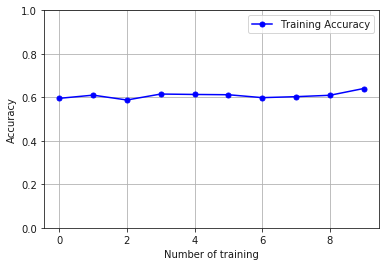

In [45]:
%matplotlib inline
from pylab import *

plt.plot(range(0,10), accuracy,
        color='blue', marker='o',
        markersize=5,
        label='Training Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.xlabel('Number of training')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')

## Report
* 選擇randomforest當最後的model
* 沒有over-fit的問題
* 利用了原本的feature_importances_去挑最好的3個
* 我先挑了五個model分別去train(DecisionTree, RandomForest, Perceptron, AdalineSGD, SVM)並挑出3個feature去判斷accurancy,並且去改參數試著把accurancy調高

-------------------------------------------

# <a name='BE'> Bayes error </a>
* [What is Bayes Error in machine learning?](https://stats.stackexchange.com/questions/302900/what-is-bayes-error-in-machine-learning)
    * Bayes error is the lowest possible prediction error that can be achieved and is the same as irreducible error
    * If one would know exactly what process generates the data, then errors will still be made if the process is random. This is also what is meant by "$y$ is inherently stochastic".
    * For example:
        * When flipping a fair coin, we know exactly what process generates the outcome (a binomial distribution)
        * However, if we were to predict the outcome of a series of coin flips, we would still make errors, because the process is inherently random (i.e. stochastic).
    * [More information](https://elitedatascience.com/bias-variance-tradeoff)    


* [Go to Bayes error in artical](#BackBE)

# <a name='OaU'>Overfitting and Underfitting</a>
* Diagnosing Bias vs. Variance
    * Bias即所謂的Underfitting，因為參數過少連Training set都會有頗大的預測誤差
    * Variance即所謂的Overfitting，因為參數過多導致過度符合Training set的資料特性，使得其無法預測較為普遍的資料集
    <img src='https://cdn-images-1.medium.com/max/800/1*K81NAVYYMziK0lnoAi6C4g.png' width='500'></img>
------------------------------------------------------------------------
* 下圖紅色的線表用cross-validation，粉紅色的線是指用training set的情況
<br />
<br />
<img src='https://cdn-images-1.medium.com/max/800/1*kKZkBwM1H841yGKGXqKLjw.png' width='500'></img>
<br />
<br />
* 從上圖可知，看到當參數增加時，會使得用來訓練的Training set的預測落差漸漸趨近於0，但是用來表示cross-validation的線條，會因為參數增加造成的**overfitting的問題**，使得其預測誤差在某個臨界點後便開始急遽的上升
------------------------------------------------------------------------

<img src='https://cdn-images-1.medium.com/max/800/1*XxJZsjluGbWbE99cE3nTDg.png' width='500'></img>
<br />
* 從上圖中可以很清楚地看出，當參數很少時(Bias)，cv(cross validation)地預測落差會跟training set的預測落差都是差不多的，**都很大，即Underfitting**
* 而當參數非常多時(Variance)，cv的預測落差會很大，而training set的預測落差卻剛好相反：非常小，即Overfitting

# How to fix Overfitting and Underfitting?
* 使用Regularization的方法來處理
    * 問題：我們的λ要用多大呢？
    * 假設我們使用Regularization來解決Linear regression
    <br />
    <img src='https://cdn-images-1.medium.com/max/800/1*u93vLZIQfYrmdIxus5qQsg.png' width='500'></img>
    <br />
    * 不同的λ將可能造成不同的問題：若是λ很大的話，將會使得所有的參數都變得很小而沒什麼影響力，這會造成Underfitting的問題；若是λ很小的則就像是λ根本沒加進去一樣，仍然沒解決Overfitting的問題
* 用Training set, Cross Validation set跟Test set的概念
    * 也就是我們藉由代入不同的λ來訓練模型，再將cross validation的資料丟入這些不同λ的模型得出不同的誤差值，最後再從中得到最好的λ、模型(最小的誤差值)
<img src='https://cdn-images-1.medium.com/max/800/1*cQoB1owDnzLEqBc0CD_MGg.png' width='500'></img>
* [Reference](https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-6-2-diagnosing-5a9e43db4593)
* [Go to Learning Theory](#LT)

# <a name='LC'>Learning Curves</a>
* 學習曲線為一個觀察隨著訓練樣本數(m)不斷增加，J_train跟J_cv的變化圖形(這邊樣本數增加指的是J_train，J_cv會維持原樣)

-------------------------------------------------------
<img src='https://cdn-images-1.medium.com/max/800/1*HzKVldFeBbV82zOptZPfzA.png' width='500'></img>
* 假設在預測模型是一個已經調整到非常不錯的狀態，那麼我們可以看到隨著樣本數增加，J_train也會緩緩地上升，而J_cv會因為參數漸漸地精準起來而隨之下降

-------------------------------------------------------

* Underfitting(bias)的問題時呢?
<img src='https://cdn-images-1.medium.com/max/800/1*beG7jSm_V5rs2UrHhRVTWw.png' width='500'></img>
* 可以發現J_train初期會大幅上升，到一定程度後就趨於緩慢，而J_cv則會在下降到一定程度後便幾乎不再下降，而兩者趨同
* **Underfitting的模型有幾個特點：J_train與J_cv近似、都是在一個很高的誤差**
    * 也可推測出，就算訓練樣本數不斷增加，對於J_cv的改善也是極其的有限，因此，對於bias問題來說，增加訓練樣本數並不是一個合理的選擇
-------------------------------------------------------

* Overfitting(variance)的問題時呢?
<img src='https://cdn-images-1.medium.com/max/800/1*V3sWvKNn3By52PDhT-sR3g.png' width='500'></img>
* J_train會持續的緩慢上升，而J_cv會持續地緩慢下降
* **Overfitting模型的特點是：J_cv的誤差將明顯大於J_train**
    * 可以推測出，當訓練樣本數持續增加後，將會漸漸改善J_cv的預測準度，因此對於variance問題來說，增加樣本數是一個可行的解決辦法
    * 那為什麼bias就不是呢？
        * 想像：bias就像是一個不求長進的模型(也因此不會有進步的可能)，相反地，variance是一個自我要求極高的模型，當這個模型吹毛求疵的算出了幾乎全部的預測後，那麼代表它離完美的預測也不遠了
-------------------------------------------------------
## 最後問題：當今天我們的模型發生令人無法接受的誤差時，我們有哪些解決辦法呢？
<img src='https://cdn-images-1.medium.com/max/800/1*4BMOw8uglkjT9BKB7SCMZQ.png' width='500'></img>

* 解決High variance，也就是Overfitting：
    * 更多的訓練樣本、少一點feature、加大$λ$都是可行的辦法
* 解決High bias，即Underfitting：
    * 更多的feature、增加多項式、降低$λ$都是可行的辦法
* 到Neural Network上面，當network的結構越為簡單時，代表其越有著Underfitting的問題；而當network的結構越為複雜時，代表其除了運算成本很高外，還可能有著Overfitting的問題，也因此可以適時導入Regularization來解決

-------------------------------------------------------
* [Reference](https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-6-2-diagnosing-5a9e43db4593)
* [Go to Learning Curves](#BackLC)

# <a name='WD'>Weight decay</a>
* 在實際應用中，為了避免Network過度擬合，必須對cost function加入正則項（regularization）
<img src='https://cdn-images-1.medium.com/max/800/0*-A0oYQUiHRONK7Eo.jpg' width='300'></img>
* 主要目的是「抑制更新參數的幅度」，在訓練模型時預測的結果會通過損失函數評估與真實值的差距，再藉由梯度下降更新參數，而權重衰減的方法是在損失函數加上一個懲罰項
* 例如:線性回歸
<img src='https://cdn-images-1.medium.com/max/800/0*4GUxXJhTgpx5t98C.png' width='150'></img>
    * 損失函數為 loss(w, b)，我們在這個損失函數後加上一個帶有 L2 范數的懲罰項，其中 λ 是懲罰項的倍率，當 λ=0 時，則權重衰減不會發生；當 λ 越大時，懲罰的比率較高，權重衰減的程度也就跟著變大
* [Reference](https://medium.com/@prairie5270/%E4%BD%BF%E7%94%A8-tensorflow-%E4%BA%86%E8%A7%A3%E6%AC%8A%E9%87%8D%E8%A1%B0%E6%B8%9B-70d4dfac9e15)
* [Go to Weight decay](#BackWD)

# <a name='RR'>Ridge Regression</a>
* Feature extraction的其中一種方法是Ridge Regression
* 目前所學到的Feature extraction:
    * 子集選擇:
        * 例如: 去掉變化值較小的feature
    * 維度減少:
        * 例如: Perceptron
    * <font color='Red'>收縮方式</font>(Shrinkage method)，又稱正則化: 
        * Ridge Regression
        * LASSO
* Ridge Regression 方法是在平方誤差的基礎上增加正則項，如下公式:
$$\arg\min_{\boldsymbol{w},b}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert^{2}$$
-----------------------------------------
* 主要概念是希望透過確定$λ$的值使得在Variance和bias之間達到平衡:
    * 隨著$λ$的增大，model的Variance減小而bias增大
-----------------------------------------
* 幾何意義:
    * 以兩個變量為例，殘差平方和可以表示為$w_{1}, w_{2}$的一個二次函數，是一個在三維空間中的拋物面，可以用等值線來表示
    * Ridge Regression限定了所有的迴歸係數的平方和不大於$t$
    * 限制條件$w_{1}^{2}+w_{2}^{2}<t$，相當於在二維平面的一個圓，這個時候等值線與圓相切得點便是在約束條件下的最優點，如下圖:
    <img src='https://pic3.zhimg.com/80/v2-a13db3079fd191c00150eec088c1530e_hd.jpg' width='300'></img>
-----------------------------------------
* 性質:
    1. 當$λ=0$，得到的解釋最小二乘解
    2. $λ$越大時，迴歸係數$w$趨向於0，約束項$t$很小
-----------------------------------------
* [Reference1](https://blog.csdn.net/google19890102/article/details/27228279)
* [Reference2](https://zhuanlan.zhihu.com/p/30535220)
* [Go to Weight decay](#BackWD)

# <a name='LASSO'>LASSO</a>
* LASSO(The Least Absolute Shrinkage and Selection Operator)是另一種縮減方法，將迴歸係數收縮在一定的區域內
* 特點是在擬合廣義線性模型的同時進行變量篩選(Variable Selection)和複雜度調整(Regularization)
* 不論目標因變量(dependent/response varaible)是連續的(continuous)，還是二元或者多元離散的(discrete)， 都可以用LASSO回歸建模然后預測
    * 變量篩選是指不把所有的變量都放入模型中進行擬合，而是有選擇的把變量放入模型從而得到更好的性能參數
    * 複雜度調整是指通過一系列參數控制模型的複雜度，從而避免過度擬合(Overfitting)
* LASSO回歸復雜度調整的程度由參數λ來控制，λ越大對變量較多的線性模型的懲罰力度就越大，從而最終獲得一個變量較少的模型
* LASSO回歸與Ridge回歸同屬于一個被稱為Elastic Net的廣義線性模型家族
-------------------------------------------
* 主要概念是構造一個一階懲罰函數獲得一個精練的model，通過最終確定一些變量的係數為0來進行特徵選擇
* 懲罰項為:
$$\sum_{i=1}^n|w_{i}|\leq{t}$$
* 與Ridge Regression不同的是約束條件使用絕對值得一階懲罰函數代替了平方和的二階函數
* LASSO當$λ$很小時，一些係數會隨之變為0，而Ridge Regression卻很難使得某個係數恰好縮減為0
-------------------------------------------
* 幾和意義:
    * 同樣用兩個變量為例，LASSO的約束條件可以用方型表示，如下圖:
    <img src='https://pic2.zhimg.com/80/v2-e16c01b5088ed0e6dc37833002e7b769_hd.jpg'></img>
    * 相比圓，方型的頂點更容易與拋物面相交，頂點就意味著對應很多係數為0，也就意味著，LASSO起到很好的篩選變量的作用
* 雖然LASSO懲罰函數只是做了細微變化，但是Ridge Regression可以直接通過矩陣運算得到回歸係數，LASSO的計算變得相對複雜，由於懲罰項中含有絕對值，此函數的導數是連續不光滑，所以無法進行求導並使用梯度下降優化
-----------------------------------------
* [Reference1](https://www.itread01.com/articles/1476186377.html)
* [Go to Weight decay](#BackWD)

# <a name='RANSAC'>RANSAC</a>
* 又稱隨機抽樣一致算法（RANdom SAmple Consensus，RANSAC）
* 採用疊代的方式從一組包含離群的被觀測數據中估算出數學模型的參數
* RANSAC是一個非確定性算法，在某種意義上說，會產生一個在一定機率下合理的結果，而更多次的疊代會使這一機率增加
-----------------------------------------
* [Reference](https://zh.wikipedia.org/wiki/%E9%9A%A8%E6%A9%9F%E6%8A%BD%E6%A8%A3%E4%B8%80%E8%87%B4)
* [Go to Ignoring Outliers using RANSAC](#BackRANSAC)

# <a name='I'>Inliers</a>
* 無彈性的定義: 全部數據分為 inlier 和 outlier
    * inlier 是位在迴歸函數上面的數據 
    * outlier 是不在迴歸函數上面的數據
* 有彈性的定義: 全部數據分為 inlier 和 outlier
    * inlier 是距離迴歸函數夠近的數據
    * outlier 是距離迴歸函數太遠的數據
-----------------------------------------
* [Reference](http://www.csie.ntnu.edu.tw/~u91029/Regression.html)
* [Go to Ignoring Outliers using RANSAC](#BackRANSAC)

# <a name='MAD'>MAD</a>
* MAD（Median absolute deviation, 中位數絕對偏差）是單變量數據集中樣本差異性的穩健度量
* 對於數據集中異常值的處理比標準差更具有彈性，可以大大減少異常值對於數據集的影響
* 對於單變量數據集 $X={X_{1},X_{2},X_{3},...,X_{n}}$，MAD的計算公式為： 
$$mad(X)=median(\left| X_{i}−median(X)\right| )$$
* 對於矢量 ds=(1,1,2,2,4,6,9)，中位數為2，ds中的數關於2的絕對偏差為(1,1,0,0,2,4,7)，所以ds的mad值為1
* 計算方法:
    * 先對於一個set先找出中位數$X_{i}$
    * 將set裡的每個值減去$X_{i}$，再取絕對值
    * 最後再找一次中位數，該數及為MAD的值
-------------------------------------
* [Reference](https://hk.saowen.com/a/c3d66dc23638d71b5e441d3e463ab16416f760d0ad4f32877b1ce67527cad3ac)
* [Go to MAD](#BackMAD)